# Visualize and Analyze Data

This notebook will explore the data we downloaded in the `Customize and Access Data` notebook by performing the following steps:

1. Read in ATL07 data and plot against MODIS Corrected Reflectance (true color) imagery
2. Overlay ATL07 data over MODIS IST
3. Extract MODIS IST values along ICESat-2 heights
4. Extract ICESat-2 heights along MODIS IST values.
5. Plot MODIS IST and ICESat-2 heights
   

### Import packages

We'll only have to do these manual installs for the dry-run. Luis will get these installed prior to AGU!

In [ ]:
# Need to install `plotly` on top of Pangeo
!conda install -c plotly plotly=4.3.0 -y

# Need to instal `awscli` on top of Pangeo 
!conda install awscli -y
!conda list | grep pyproj

# Need to upgrade `pyproj` on this Pangeo environment. Had some issues getting this to install in our environment but this worked:
import sys
!{sys.executable} -m pip install pyproj==2.4.1

In [ ]:
#%run functions.py

In [1]:
from collections import defaultdict

from osgeo import gdal, osr
import math
import h5py
import xarray as xr
import pyproj
import pandas as pd
from shapely.geometry import Point,Polygon

import pyresample as prs
import cartopy.crs as ccrs
from matplotlib import pyplot as plt
import hvplot.pandas  # Adds the 'hvplot' method to pandas objects
import hvplot.xarray  # Adds the 'hvplot' method to xarray objects
#import plotly.graph_objects as go
#from plotly.offline import iplot
import rasterio
import functions

# from pathlib import Path
# import numpy as np
#import geopandas as gpd
from datetime import datetime, timedelta

%matplotlib inline

### Load data from Amazon s3 bucket

We'll only have to do this manual s3 loading for the dry-run. Luis will get the outputs copied to the environment prior to AGU!

In [2]:
!aws --no-sign-request --region=us-west-2 s3 sync s3://nsidc-agu-tutorial-data/ Outputs

download: s3://nsidc-agu-tutorial-data/processed_ATL07-01_20190323211343_13050201_002_01.h5 to Outputs/processed_ATL07-01_20190323211343_13050201_002_01.h5
download: s3://nsidc-agu-tutorial-data/processed_ATL07-01_20190323101341_12980201_002_01.h5 to Outputs/processed_ATL07-01_20190323101341_12980201_002_01.h5


## Read in our data

We will be using a few different packages to bring our data in...

* [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/getting_started/overview.html)
    * Pandas is built on top of NumPy and provides easy to work with data structures. The pandas dataframe is a 2-D tabular data structure with labeled axes. 
* [GeoPandas GeoDataFrame](http://geopandas.org/reference/geopandas.GeoDataFrame.html) 
    * A GeoDataFrame object is a pandas.DataFrame that has a column with geometry.
* [Gdal](https://pypi.org/project/GDAL/)
    * Tools for programming and manipulating the Geospatial Data Abstraction Library (GDAL).
* [Rasterio](https://rasterio.readthedocs.io/en/stable/index.html)
    * Rasterio reads and writes raster formats including GeoTIFF.
* [Xarray](http://xarray.pydata.org/en/stable/index.html)
    * Inspired by Pandas, xarray introduces labels in the form of dimensions, coordinates and attributes on top of raw NumPy-like arrays, which allows for a more intuitive, more concise, and less error-prone developer experience.

### Load ATL07 granules into dataframes

We will start by defining variables to extract and combine as a single dataframe:

In [6]:
VARIABLES = {
    'ATL07': [
        '/gt1l/sea_ice_segments/delta_time',
        '/gt1l/sea_ice_segments/latitude',
        '/gt1l/sea_ice_segments/longitude',
        '/gt1l/sea_ice_segments/heights/height_segment_confidence',
        '/gt1l/sea_ice_segments/heights/height_segment_height',
        '/gt1l/sea_ice_segments/heights/height_segment_quality',
        '/gt1l/sea_ice_segments/heights/height_segment_surface_error_est',
        '/gt1l/sea_ice_segments/heights/height_segment_length_seg',
        '/gt2l/sea_ice_segments/delta_time',
        '/gt2l/sea_ice_segments/latitude',
        '/gt2l/sea_ice_segments/longitude',
        '/gt2l/sea_ice_segments/heights/height_segment_confidence',
        '/gt2l/sea_ice_segments/heights/height_segment_height',
        '/gt2l/sea_ice_segments/heights/height_segment_quality',
        '/gt2l/sea_ice_segments/heights/height_segment_surface_error_est',
        '/gt2l/sea_ice_segments/heights/height_segment_length_seg',
        '/gt3l/sea_ice_segments/delta_time',
        '/gt3l/sea_ice_segments/latitude',
        '/gt3l/sea_ice_segments/longitude',
        '/gt3l/sea_ice_segments/heights/height_segment_confidence',
        '/gt3l/sea_ice_segments/heights/height_segment_height',
        '/gt3l/sea_ice_segments/heights/height_segment_quality',
        '/gt3l/sea_ice_segments/heights/height_segment_surface_error_est',
        '/gt3l/sea_ice_segments/heights/height_segment_length_seg'
    ]
}

#### We will use the load_icesat2_as_dataframe function from our functions module to load points from our ATL07 files:

In [7]:
# Load ATL07 granules and combine into single ATL07 dataframe

df_07_101341 = functions.load_icesat2_as_dataframe('./Outputs/processed_ATL07-01_20190323101341_12980201_002_01.h5', VARIABLES)
df_07_211343 = functions.load_icesat2_as_dataframe('./Outputs/processed_ATL07-01_20190323211343_13050201_002_01.h5', VARIABLES)

atl07_frames = [df_07_101341, df_07_211343]
df_atl07 = pd.concat(atl07_frames,ignore_index=True)

df_atl07

,beam,delta_time,height_segment_confidence,height_segment_height,height_segment_length_seg,height_segment_quality,height_segment_surface_error_est,latitude,longitude,filename
0,gt2l,3.857279e+07,0.010119,0.050335,14.220163,1,0.019096,79.999964,152.056425,processed_ATL07-01_20190323101341_12980201_002...
1,gt2l,3.857279e+07,0.008934,0.153305,13.467511,1,0.018029,79.999903,152.056321,processed_ATL07-01_20190323101341_12980201_002...
2,gt2l,3.857279e+07,0.014152,0.144036,12.918651,1,0.020858,79.999851,152.056231,processed_ATL07-01_20190323101341_12980201_002...
3,gt2l,3.857279e+07,0.008798,0.226246,12.904084,1,0.027372,79.999799,152.056142,processed_ATL07-01_20190323101341_12980201_002...
4,gt2l,3.857279e+07,0.008230,0.518152,11.704844,1,0.028602,79.999752,152.056061,processed_ATL07-01_20190323101341_12980201_002...
...,...,...,...,...,...,...,...,...,...,...
583881,gt1l,3.861208e+07,0.018223,0.021864,117.437698,0,0.022440,79.997127,143.458730,processed_ATL07-01_20190323211343_13050201_002...
583882,gt1l,3.861208e+07,0.015597,-0.008414,116.478844,0,0.022333,79.997591,143.458152,processed_ATL07-01_20190323211343_13050201_002...
583883,gt1l,3.861208e+07,0.022903,-0.027518,127.496407,0,0.017136,79.998125,143.457491,processed_ATL07-01_20190323211343_13050201_002...
583884,gt1l,3.861208e+07,NaN,NaN,171.476334,0,NaN,79.998790,143.456659,processed_ATL07-01_20190323211343_13050201_002...


#### We will use the convert_to_gdf function from our functions module to convert our DataFrame with 'longitude' and 'latitude' columns to a GeoDataFrame:

In [8]:
gdf_07_101341 = functions.convert_to_gdf(df_07_101341)
gdf_07_211343 = functions.convert_to_gdf(df_07_211343)
gdf_atl07 = functions.convert_to_gdf(df_atl07)

gdf_atl07

,beam,delta_time,height_segment_confidence,height_segment_height,height_segment_length_seg,height_segment_quality,height_segment_surface_error_est,latitude,longitude,filename,geometry
0,gt2l,3.857279e+07,0.010119,0.050335,14.220163,1,0.019096,79.999964,152.056425,processed_ATL07-01_20190323101341_12980201_002...,POINT (152.05643 79.99996)
1,gt2l,3.857279e+07,0.008934,0.153305,13.467511,1,0.018029,79.999903,152.056321,processed_ATL07-01_20190323101341_12980201_002...,POINT (152.05632 79.99990)
2,gt2l,3.857279e+07,0.014152,0.144036,12.918651,1,0.020858,79.999851,152.056231,processed_ATL07-01_20190323101341_12980201_002...,POINT (152.05623 79.99985)
3,gt2l,3.857279e+07,0.008798,0.226246,12.904084,1,0.027372,79.999799,152.056142,processed_ATL07-01_20190323101341_12980201_002...,POINT (152.05614 79.99980)
4,gt2l,3.857279e+07,0.008230,0.518152,11.704844,1,0.028602,79.999752,152.056061,processed_ATL07-01_20190323101341_12980201_002...,POINT (152.05606 79.99975)
...,...,...,...,...,...,...,...,...,...,...,...
583881,gt1l,3.861208e+07,0.018223,0.021864,117.437698,0,0.022440,79.997127,143.458730,processed_ATL07-01_20190323211343_13050201_002...,POINT (143.45873 79.99713)
583882,gt1l,3.861208e+07,0.015597,-0.008414,116.478844,0,0.022333,79.997591,143.458152,processed_ATL07-01_20190323211343_13050201_002...,POINT (143.45815 79.99759)
583883,gt1l,3.861208e+07,0.022903,-0.027518,127.496407,0,0.017136,79.998125,143.457491,processed_ATL07-01_20190323211343_13050201_002...,POINT (143.45749 79.99813)
583884,gt1l,3.861208e+07,NaN,NaN,171.476334,0,NaN,79.998790,143.456659,processed_ATL07-01_20190323211343_13050201_002...,POINT (143.45666 79.99879)


### Load MODIS Corrected Reflectance (true color) image and MODIS IST image

GeoTIFFs were created using the NASA Worldview snapshot feature: </n> 

MODIS Corrected Reflectance: https://go.nasa.gov/2OjfDSa </n>

MODIS IST: https://go.nasa.gov/34fBnp8

We'll read in the projection information below to help inform our plotting projection parameters in the next step:

In [17]:
# Read geotiff images from gdal 

gdal.UseExceptions()

fname_cr = './Outputs/snapshot-2019-03-23T00_00_00Z_polar.tiff'
fname_ist = './Outputs/snapshot-2019-03-23T00_00_00Z-IST.tiff'

ds_cr = gdal.Open(fname_cr)
ds_ist = gdal.Open(fname_ist)
#data = ds.ReadAsArray()
#gt = ds.GetGeoTransform()
proj_cr = ds_cr.GetProjection()
proj_ist = ds_ist.GetProjection()

inproj = osr.SpatialReference()
inproj.ImportFromWkt(proj_cr)

#Print proj4 strings for each GeoTIFF
proj4_cr = inproj.ExportToProj4()
print('MODIS True Color proj4:', proj4_cr)
inproj.ImportFromWkt(proj_ist)
proj4_ist = inproj.ExportToProj4()
print('MODIS IST proj4:',proj4_cr)

MODIS True Color proj4: +proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs 
MODIS IST proj4: +proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs 


### Load MODIS Ice Surface Temperature file

There were 13 granules returned over our time and area of interest. We can use Earthdata Search to easily visualize the coverage of each granule:
[MODIS Earthdata Search link](https://search.earthdata.nasa.gov/search/granules?p=C1000001160-NSIDC_ECS&q=mod29&sb=140%2C72%2C153%2C80&m=80.14349326047419!-42.27686414753069!0!0!0!0%2C2&qt=2019-03-23T00%3A00%3A00.000Z%2C2019-03-23T23%3A59%3A59.999Z&tl=1557787959!4!)

Let's choose a single MODIS granule to be used in our analysis below. 

Out of the 13 returned, these all have full coverage over our study area:

* MOD29.A2019082.0810.006.2019082191746.hdf
* MOD29.A2019082.0630.006.2019082191633.hdf
* MOD29.A2019082.0455.006.2019082132032.hdf
* MOD29.A2019082.0945.006.2019082191513.hdf

And after viewing the browse images, this looks to have the best data coverage:

* MOD29.A2019082.0140.006.2019082132036.hdf


#### Now let's load our MOD29 file into xarray:

In [18]:
# Define local filepath and open as xarray

filepath = './Outputs/MOD29_A2019082_0140_006_2019082132036_HEGOUT.hdf'

mod29 = xr.open_dataset(filepath)
mod29

<xarray.Dataset>
Dimensions:                           (Along_swath_lines_1km:MOD_Swath_Sea_Ice: 932, Coarse_swath_lines_5km:MOD_Swath_Sea_Ice: 932, Coarse_swath_pixels_5km:MOD_Swath_Sea_Ice: 389, Cross_swath_pixels_1km:MOD_Swath_Sea_Ice: 389)
Dimensions without coordinates: Along_swath_lines_1km:MOD_Swath_Sea_Ice, Coarse_swath_lines_5km:MOD_Swath_Sea_Ice, Coarse_swath_pixels_5km:MOD_Swath_Sea_Ice, Cross_swath_pixels_1km:MOD_Swath_Sea_Ice
Data variables:
    Latitude                          (Coarse_swath_lines_5km:MOD_Swath_Sea_Ice, Coarse_swath_pixels_5km:MOD_Swath_Sea_Ice) float32 ...
    Longitude                         (Coarse_swath_lines_5km:MOD_Swath_Sea_Ice, Coarse_swath_pixels_5km:MOD_Swath_Sea_Ice) float32 ...
    Sea_Ice_by_Reflectance            (Along_swath_lines_1km:MOD_Swath_Sea_Ice, Cross_swath_pixels_1km:MOD_Swath_Sea_Ice) float32 ...
    Sea_Ice_by_Reflectance_Pixel_QA   (Along_swath_lines_1km:MOD_Swath_Sea_Ice, Cross_swath_pixels_1km:MOD_Swath_Sea_Ice) float32 ...
    Ice_Surface_Temperature           (Along_swath_lines_1km:MOD_Swath_Sea_Ice, Cross_swath_pixels_1km:MOD_Swath_Sea_Ice) float32 ...
    Ice_Surface_Temperature_Pixel_QA  (Along_swath_lines_1km:MOD_Swath_Sea_Ice, Cross_swath_pixels_1km:MOD_Swath_Sea_Ice) float32 ...
Attributes:
    HDFEOSVersion:     HDFEOS_V2.20
    StructMetadata.0:  GROUP=SwathStructure\n\tGROUP=SWATH_1\n\t\tSwathName="...

## Visualize ICESat-2 height values 

We can visualize the ICESat-2 track locations and height values overlayed with MODIS Corrected Reflectance and MODIS Ice Surface Temperature. We should see higher ATL07 heights along fast ice, with lower heights over thin ice and then increasing height over drift ice. 

In [20]:
# Read in data using rasterio

fname_cr = './Outputs/snapshot-2019-03-23T00_00_00Z_polar.tiff'
fname_ist = './Outputs/snapshot-2019-03-23T00_00_00Z-IST.tiff'
source_ist = rasterio.open(fname_ist, 'r')
source_cr = rasterio.open(fname_cr, 'r')
bounds_cr = (source_cr.bounds.left, source_cr.bounds.right, \
          source_cr.bounds.bottom, source_cr.bounds.top)
bounds_ist = (source_ist.bounds.left, source_ist.bounds.right, \
          source_ist.bounds.bottom, source_ist.bounds.top)

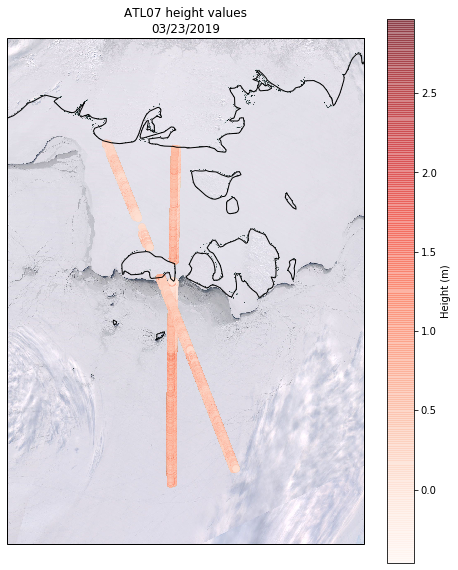

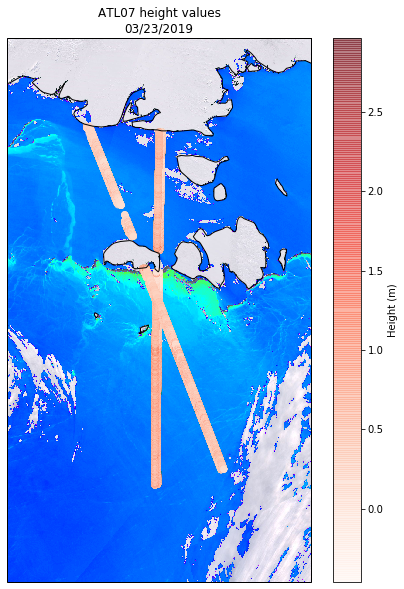

In [34]:
# Plot ICESat-2 over MODIS Corrected Reflectance
fig = plt.figure(figsize=(8, 10))
img = plt.imread(fname_cr)
plot_proj = ccrs.Stereographic(central_longitude=-45, central_latitude=90, 
                               false_easting=0, false_northing=0,
                               true_scale_latitude=70)
ax = plt.axes(projection=plot_proj)
plt.title('ATL07 height values\n'
          '03/23/2019')

# set a margin around the data
ax.set_xmargin(0.05)
ax.set_ymargin(0.10)

# add the image. Because this image was a tiff, the "origin" of the image is in the upper left corner
ax.imshow(img, origin='upper', extent=bounds_cr, transform=plot_proj)
ax.coastlines(resolution='50m', color='black', linewidth=1)
              
heights = ax.scatter(gdf_atl07.longitude, gdf_atl07.latitude, transform=ccrs.Geodetic(),
          c=gdf_atl07.height_segment_height,
          cmap='Reds', alpha=0.5) 

cbar = fig.colorbar(heights, ax=ax)
cbar.set_label('Height (m)')


# Plot ICESat-2 over MODIS IST
fig = plt.figure(figsize=(8, 10))
img = plt.imread(fname_ist)
plot_proj = ccrs.Stereographic(central_longitude=-45, central_latitude=90, 
                               false_easting=0, false_northing=0,
                               true_scale_latitude=70)

ax = plt.axes(projection=plot_proj)
plt.title('ATL07 height values\n'
          '03/23/2019')

# set a margin around the data
ax.set_xmargin(0.05)
ax.set_ymargin(0.10)

# add the image. Because this image was a tiff, the "origin" of the image is in the upper left corner
ax.imshow(img, origin='upper', extent=bounds_ist, transform=plot_proj)
ax.coastlines(resolution='50m', color='black', linewidth=1)

heights = ax.scatter(gdf_atl07.longitude, gdf_atl07.latitude, transform=ccrs.Geodetic(),
          c=gdf_atl07.height_segment_height,
          cmap='Reds', alpha=0.5)              

cbar = fig.colorbar(heights, ax=ax)
cbar.set_label('Height (m)')
plt.show()


#### How does this look in 3d?

Coming soon...


In [ ]:
# From OpenAltimetry notebook:

# # Paste the OpenAltimetry selection parameters here
# OA_REFERENCE_URL = 'minx=72.0476&miny=36.6165&maxx=72.0505&maxy=36.6214&date=2019-05-02&trackId=516'
# # We populate a list with the photon data using the OpenAltimetry API, no HDF! 
# OA_URL = 'https://openaltimetry.org/data/icesat2/getPhotonData?client=jupyter&' + OA_REFERENCE_URL

# OA_PHOTONS = ['Noise', 'Low', 'Medium', 'High']
# # OA_PLOTTED_BEAMS = [1,2,3,4,5,6] you can select up to 6 beams for each ground track.
# # Some beams may not be usable due cloud covering or QC issues.
# OA_BEAMS = [3,4]

# df_beams = []
# oa_plots = []

# # This function will request the 6 tracks using OpenAltimetry's API
# def getPhotonData():
#     series = []
#     beam_index = 0;
#     for beam in OA_BEAMS:
#         beam_index += 1
#         b_url = OA_URL + '&beam=' + str(beam)
#         print(b_url)
#         print('Requesting Beam {}'.format(beam_index))
#         r = requests.get(b_url)
#         data = r.json()
#         series.append(data)
#     print ('Data requests completed you can now plot it on the next cell...')
#     return series

        
# photon_cloud = getPhotonData()

# track_index = 0
# for track in photon_cloud:
#     track_index +=1
#     for photons in track['series']:
#         if any(word in photons['name'] for word in OA_PHOTONS):
#             series = []
#             for p in photons['data']:
#                 series.append({
#                     'lat': p[0],
#                     'lon': p[2],
#                     'h': p[1]
#                 })
#             if (len(series) > 0):
#                 df = pd.DataFrame.from_dict(series)
#                 df.name = 'Beam ' + str(track_index) + ' ' + photons['name']
#                 df_beams.append(df) 

# for df in df_beams:
#     oa_plots.append(go.Scatter3d(name=df.name, x=df['lat'], y=df['lon'], z=df['h'], mode='markers',
#                                     marker=dict(
#                                         size=1,
#                                         color=df['h'],
#                                         colorscale='Viridis',   # choose a colorscale
#                                         opacity=0.8
#                                     )
#                                 )
#                    )
    
    
# layout = go.Layout(
#     width=900,
#     height=600,
#     scene = dict(aspectmode = 'manual', aspectratio =dict(x=1, y=1, z=0.5),
#                  xaxis=dict(title='Latitude'), yaxis=dict(title='Longitude'), zaxis=dict(title='Elevation (m)'))
# )

# fig = go.Figure(data=oa_plots, layout=layout)  

# iplot(fig)


# # Now we can get a histogram of the beam's elevation and their description
# for df in df_beams:
#     print(df.describe())
#     df.hist('h', bins=128)
    

### Overlay ATL07 values over MODIS Ice Surface Temperature



* Plot IS-2 track on MOD29 IST data
    * Same as for WorldView but using IST
    * May need/want a land mask

Before we plot the ATL07 heights over MODIS IST, we need to convert the Ice_Surface_Temperature values to kelvins. According to the [MOD29 User Guide](https://nsidc.org/data/mod29#title11) the Ice_Surface_Temperature (IST) values are "stored as calibrated data. To convert to kelvins, use scale_factor = 0.01 and add_offset = 0.0 in the following equation:

IST = scale_factor × (calibrated data - add_offset)

The valid range for ISTs is 210 K to 313.20 K."

Let's apply this conversion to our xarray:

In [ ]:
# Apply calibrated data to kelvin conversion

mod29['Ice_Surface_Temperature'] = mod29['Ice_Surface_Temperature']*(0.01)

In [ ]:
img = mod29.Ice_Surface_Temperature.hvplot.image().redim.range(Ice_Surface_Temperature=(240, 270))
img.options(cmap='PiYG_r')
#img.options(cmap='viridis')

In [ ]:
# HOW TO ADD ATL07 HEIGHTS OVER IST, LIKE ABOVE WITH THE CORRECTED REFLECTANCE IMAGE? STARTED TO PLAY WITH HVPLOT AND THIS LED TO PAGE UNRESPONSIVE:
from holoviews.operation.datashader import datashade
datashade(atl07_df.hvplot.points(x='longitude', y='latitude'))

## Extract MODIS IST values along the ICESat-2 tracks

Now that we've visually inspected height and IST values, let's do some analysis. We will now extract MODIS IST values at each ATL07 point.

* Match up MODIS and ICESat-2 values – depending on IS-2 segment length vs. MODIS footprint, may simply do nearest neighbor, or may want to average (bin) on or the other
* Use MODIS footprint as the baseline and match/bin IS-2 to each MODIS observation

In [ ]:
min_lon, max_lon = mod29.Longitude.min(), mod29.Longitude.max()
min_lat, max_lat = mod29.Latitude.min(), mod29.Latitude.max()
mod29_boundary = Polygon(
    [
        (min_lon, min_lat), 
        (max_lon, min_lat), 
        (max_lon, max_lat), 
        (min_lon, max_lat), 
        (min_lon, min_lat)
    ]
)

### Filtering to MOD29 granule bounding box

In [ ]:
# Not sure if this is necessary since we subsetted MODIS and ATLAS data

# gdf = gdf[gdf.intersects(mod29_boundary)]
# gdf

### Converting 'delta_time' to datetime values

In [ ]:
EPOCH = datetime(2018, 1, 1, 0, 0, 0)

def convert_delta_time(delta_time):
    '''
    Convert ICESat-2 'delta_time' parameter to UTC datetime
    '''
    utc_datetime = EPOCH + timedelta(seconds=delta_time)

    return utc_datetime

In [ ]:
# gdf_all['utc_datetime'] = gdf_all['delta_time'].apply(convert_delta_time)
# gdf_all = gdf_all.drop(columns='delta_time')

gdf_single['utc_datetime'] = gdf_single['delta_time'].apply(convert_delta_time)
gdf_single = gdf_single.drop(columns='delta_time')


### Compute along track distance

In [ ]:
# Warning: rather slow operation here, takes a few minutes for 200000 points

#distance = gdf_all.groupby(['filename', 'beam']).apply(functions.compute_along_track_distance)

In [ ]:
# Warning: rather slow operation here, takes a few minutes for 200000 points
distance_single = gdf_single.groupby(['filename','beam']).apply(functions.compute_along_track_distance)

In [ ]:
# Convert pandas series to list

distance_list = distance_single.tolist()

In [ ]:
# Create new gdf with distance added

gdf_dist = gdf_single.assign(distance = distance_list)

In [ ]:
#gdf_dist = gdf_all.assign(distance = distance_list)

### Convert back to pandas dataframe

Have both for good measure (different plotting api's mainly)

In [ ]:
#df_all = pd.DataFrame(gdf_dist.drop(columns='geometry'))

df_single = pd.DataFrame(gdf_dist.drop(columns='geometry'))

### Interpolating MOD29 onto ICESat-2 points

To easily interpolate MOD29 to ICESat-2 points, we can use the `pyresample` library. The `radius_of_influence` parameter determines maximum radius to look for nearest neighbor interpolation.

In [ ]:
#icesat2_geometry_all = prs.geometry.SwathDefinition(lons=df_all['longitude'], lats=df_all['latitude'])
icesat2_geometry_single = prs.geometry.SwathDefinition(lons=df_single['longitude'], lats=df_single['latitude'])
mod29_geometry = prs.geometry.SwathDefinition(lons=mod29['Longitude'], lats=mod29['Latitude'])
#df_all['mod29_ice_surface_temperature'] = prs.kd_tree.resample_nearest(mod29_geometry, mod29['Ice_Surface_Temperature'].values, icesat2_geometry_all, radius_of_influence=1000, fill_value=np.nan)
df_single['mod29_ice_surface_temperature'] = prs.kd_tree.resample_nearest(mod29_geometry, mod29['Ice_Surface_Temperature'].values, icesat2_geometry_single, radius_of_influence=1000, fill_value=np.nan)

In [ ]:
#mask_all = df_all['mod29_ice_surface_temperature'] == 50
#df_all['mod29_ice_surface_temperature'][mask_all] = np.nan

mask_single = df_single['mod29_ice_surface_temperature'] == 50
df_single['mod29_ice_surface_temperature'][mask_single] = np.nan

## Plot MODIS IST (MOD29) and ICESat-2 height/freeboard along tracks (X-axis = position, Y-axis = IST and height)

* This should show cold IST over the fast ice with fairly flat and higher ICESat-2 heights
* Warm IST will be seen in open water, thin ice just off the fast ice boundary
    * IST will decrease along transect
    * IS-2 should show low heights, but probably low quality (at least for ATL10, if any are available)

### First, plot against time:

In [ ]:
## Using pandas plotting (matplotlib backend)
# fig, ax = plt.subplots(figsize=(10, 3))
# df_all.plot(x='utc_datetime', y='mod29_ice_surface_temperature', ax=ax)
# df_all.plot(x='utc_datetime', y='height_segment_height', ax=ax, secondary_y=True)

In [ ]:
# Using pandas plotting (matplotlib backend)
fig, ax = plt.subplots(figsize=(15, 5))
df_single.plot(x='utc_datetime', y='height_segment_height', ax=ax)
df_single.plot(x='utc_datetime', y='mod29_ice_surface_temperature', ax=ax, secondary_y=True)

### Now plot against distance

We will split the plot by each beam.

In [ ]:
# separate each beam

gt1l = df_single['beam']=='gt1l'
gt2l = df_single['beam']=='gt2l'
gt3l = df_single['beam']=='gt3l'

In [ ]:
# # separate each beam

# gt1l = df_all['beam']=='gt1l'
# gt2l = df_all['beam']=='gt2l'
# gt3l = df_all['beam']=='gt3l'

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
df_single[gt1l].plot(x='distance', y='height_segment_height', ax=ax)
df_single[gt1l].plot(x='distance', y='mod29_ice_surface_temperature', ax=ax, secondary_y=True)

fig, ax = plt.subplots(figsize=(15, 5))
df_single[gt2l].plot(x='distance', y='height_segment_height', ax=ax)
df_single[gt2l].plot(x='distance', y='mod29_ice_surface_temperature', ax=ax, secondary_y=True)

fig, ax = plt.subplots(figsize=(15, 5))
df_single[gt3l].plot(x='distance', y='height_segment_height', ax=ax)
df_single[gt3l].plot(x='distance', y='mod29_ice_surface_temperature', ax=ax, secondary_y=True)

In [ ]:
# fig, ax = plt.subplots(figsize=(15, 5))
# df_all[gt1l].plot(x='distance', y='height_segment_height', ax=ax)
# df_all[gt1l].plot(x='distance', y='mod29_ice_surface_temperature', ax=ax, secondary_y=True)

# fig, ax = plt.subplots(figsize=(15, 5))
# df_all[gt2l].plot(x='distance', y='height_segment_height', ax=ax)
# df_all[gt2l].plot(x='distance', y='mod29_ice_surface_temperature', ax=ax, secondary_y=True)

# fig, ax = plt.subplots(figsize=(15, 5))
# df_all[gt3l].plot(x='distance', y='height_segment_height', ax=ax)
# df_all[gt3l].plot(x='distance', y='mod29_ice_surface_temperature', ax=ax, secondary_y=True)

In [ ]:
# Using 'hvplot' (interactive - bokeh backend)
df_single.hvplot(x='distance', y='height_segment_height', by='beam', subplots=True).cols(1)

In [ ]:
(df_single.hvplot(x='distance', y='height_segment_height') + \
df_single.hvplot(x='distance', y='mod29_ice_surface_temperature')).cols(1)

### Plot MODIS IST vs. ICESat-2: scatterplot (X-axis = IST, Y-axis = IS-2 height)

* Should show a pretty clear relationship
    * Over fast ice: IST should be close to constant and height will also be fairly constant
    * Over drift ice, where it goes from thin ice toward thicker ice, should see height increasing as IST decreases
    * If we use IST = 271.2 K for open water and then find the IST at the first valid ATL10 value, we have the IST value at that freeboard. Then can use that relationship to get thin ice freeboard where there is ATL07 data, but not ATL10


In [ ]:
#THIS CRASHES THE HUB! 

#df_all.hvplot.scatter(x='mod29_ice_surface_temperature', y='height_segment_height', c='distance')

In [ ]:
# df_single.plot.scatter(x='mod29_ice_surface_temperature', y='height_segment_height', c='utc_datetime')
df_single.plot.scatter(x='mod29_ice_surface_temperature', y='height_segment_height')

### Data filtering by quality flag

For each beam group within each file, filter `/sea_ice_segments/heights/height_segment_height` based on `/sea_ice_segments/heights/height_segment_quality`. According to the [User Guide](https://nsidc.org/data/ATL07#title38):

height_segment_quality: a binary indicator (1 = good, 0 = bad) of segment quality

In [ ]:
qual_filter = df_single['height_segment_quality']==1

In [ ]:
# Using pandas plotting (matplotlib backend)
fig, ax = plt.subplots(figsize=(15, 5))
df_single[qual_filter].plot(x='utc_datetime', y='height_segment_height', ax=ax)
df_single[qual_filter].plot(x='utc_datetime', y='mod29_ice_surface_temperature', ax=ax, secondary_y=True)

In [ ]:
df_single[qual_filter].plot.scatter(x='mod29_ice_surface_temperature', y='height_segment_height')

#High temps are getting filtered out - more open water.

In [ ]:
## add ATL10 now? This could show coverage and show the freeboard estimate. 

### Add AMSR2 (AU_SI6) 89V-H difference to MODIS IST and ICESat-2 plots

* Difference for open water/thin ice large (~40-50 K), for thicker ice near zero (<10 K)
* Or calculate the polarization ratio (PR) = (89V – 89H)/(89V + 89H), which is commonly used in the PM sea ice community
* In theory can get concentration from PR (or 89 difference), but don’t really need to do that here.


### A couple other possibilities:
* Compare cross-over points between tracks 1298 and 1305. 
    * This is over drift ice, but might be able to correlate between them
    * Using all strong beams, there are 9 cross-over points, so there is 
* Compare 1298 repeat track from 12/22/2018 and 3/23/2019
    * For fast ice, should see an increase in height from Dec to Mar as snow depth and ice thickness increases
        * From a quick look at OA, I’m not really seeing this though
        * Not much from ATL10
        * Lots of data in ATL07, but don’t really see a connection – in fact Dec looks lower than Mar; this could be due to corrections/quality issues

### Extra Credit

#### Explore ATL03 (photon-level) heights

Load ATL03 Variables:

In [ ]:
VARIABLES = {
    'ATL03': [
        '/gt1l/heights/delta_time',
        '/gt1l/heights/h_ph',
        '/gt1l/heights/lat_ph',
        '/gt1l/heights/lon_ph',
        '/gt1l/heights/signal_conf_ph',
        '/gt2l/heights/delta_time',
        '/gt2l/heights/h_ph',
        '/gt2l/heights/lat_ph',
        '/gt2l/heights/lon_ph',
        '/gt2l/heights/signal_conf_ph',
        '/gt3l/heights/delta_time',
        '/gt3l/heights/h_ph',
        '/gt3l/heights/lat_ph',
        '/gt3l/heights/lon_ph',
        '/gt3l/heights/signal_conf_ph'
    ],

Use the load_icesat2_as_dataframe function from our functions module to load points from our ATL03 files:

In [ ]:
# Running out of memory on these:
# #df_03_103438 = functions.load_icesat2_as_dataframe('./Outputs/processed_ATL03_20190323103438_12980204_002_01.h5', VARIABLES)
# df_03_103947 = functions.load_icesat2_as_dataframe('./Outputs/processed_ATL03_20190323103947_12980205_002_01.h5', VARIABLES)
# df_03_212915 = functions.load_icesat2_as_dataframe('./Outputs/processed_ATL03_20190323212915_13050203_002_01.h5', VARIABLES)
# #df_03_213440 = functions.load_icesat2_as_dataframe('./Outputs/processed_ATL03_20190323213440_13050204_002_01.h5', VARIABLES)


#atl03_frames = [df_03_103438, df_03_103947, df_03_212915, df_03_213440]
#atl03_df = pd.concat(atl03_frames,ignore_index=True)
